In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd

path = r"..\News_Category_Dataset_v3.json"

df = pd.read_json(path, lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


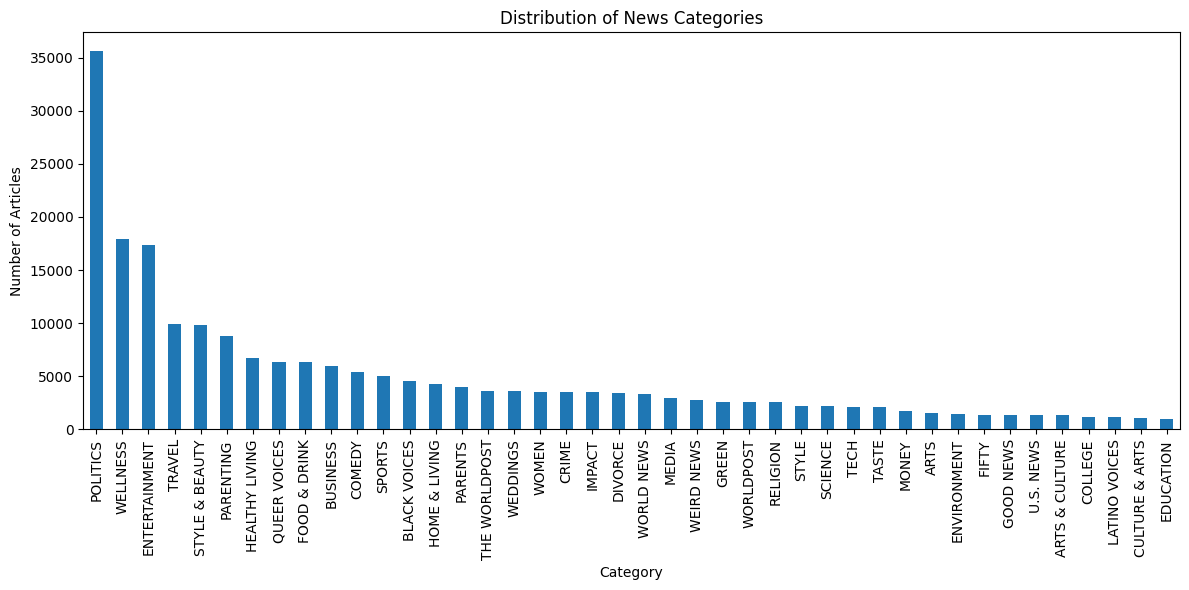

In [3]:
import matplotlib.pyplot as plt
# Count unique categories
category_counts = df['category'].value_counts()

# Plot the category distribution
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [4]:
# Define the categories to keep
categories_to_keep = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING']

# Filter the DataFrame
filtered_df = df[df['category'].isin(categories_to_keep)]

filtered_df.head()

,link,headline,category,short_description,authors,date
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
20,https://www.huffpost.com/entry/golden-globes-r...,Golden Globes Returning To NBC In January Afte...,ENTERTAINMENT,"For the past 18 months, Hollywood has effectiv...",,2022-09-20
21,https://www.huffpost.com/entry/biden-us-forces...,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS,President issues vow as tensions with China rise.,,2022-09-19
24,https://www.huffpost.com/entry/ukraine-festiva...,‘Beautiful And Sad At The Same Time’: Ukrainia...,POLITICS,An annual celebration took on a different feel...,Jonathan Nicholson,2022-09-19
28,https://www.huffpost.com/entry/james-cameron-f...,James Cameron Says He 'Clashed' With Studio Be...,ENTERTAINMENT,"The ""Avatar"" director said aspects of his 2009...",Ben Blanchet,2022-09-18


In [5]:
headline=filtered_df['headline']
category=filtered_df['category']

In [6]:
import nltk
from nltk.corpus import stopwords

text=headline.apply(lambda x: str(x).split())
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
text=text.apply(lambda x : ' '.join([word for word in x if word not in stop_words]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\javier\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(headline)
sequences = tokenizer.texts_to_sequences(headline)
word_index = tokenizer.word_index

In [8]:
data = pad_sequences(sequences, maxlen=100,)

In [9]:
label_vectorizer=tf.keras.layers.StringLookup(num_oov_indices=0)
label_vectorizer.adapt(category)
labels=label_vectorizer(category)

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
text_train, text_test, labels_train, labels_test = train_test_split(data, labels.numpy(), test_size=0.2, random_state=101)

In [11]:
text_train=tf.data.Dataset.from_tensor_slices(text_train)
text_test=tf.data.Dataset.from_tensor_slices(text_test)

labels_train=tf.data.Dataset.from_tensor_slices(labels_train)
labels_test=tf.data.Dataset.from_tensor_slices(labels_test)

train_dataset=tf.data.Dataset.zip(text_train,labels_train)
test_dataset=tf.data.Dataset.zip(text_test,labels_test)

In [12]:
train_dataset=train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE).batch(128)
test_dataset=test_dataset.cache().prefetch(tf.data.AUTOTUNE).batch(128)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,)),
    tf.keras.layers.Embedding(input_dim=30000, output_dim=128,),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(label_vectorizer.get_vocabulary()), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 98, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 98, 80)         │        54,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 98, 40)         │        16,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,003,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,964,838 (18.94 MB)

 Trainable params: 4,964,838 (18.94 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
es=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

In [16]:
history = model.fit(train_dataset, epochs=30, validation_data=test_dataset,callbacks=[es,])

Epoch 1/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 98s 150ms/step - accuracy: 0.7427 - loss: 0.7171 - val_accuracy: 0.8487 - val_loss: 0.4675
Epoch 2/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 97s 156ms/step - accuracy: 0.8972 - loss: 0.3160 - val_accuracy: 0.8567 - val_loss: 0.4698
Epoch 3/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 96s 155ms/step - accuracy: 0.9411 - loss: 0.1881 - val_accuracy: 0.8503 - val_loss: 0.5570
Epoch 4/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 93s 150ms/step - accuracy: 0.9623 - loss: 0.1195 - val_accuracy: 0.8458 - val_loss: 0.6878
Epoch 5/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 93s 150ms/step - accuracy: 0.9745 - loss: 0.0796 - val_accuracy: 0.8369 - val_loss: 0.8062
Epoch 6/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 92s 148ms/step - accuracy: 0.9806 - loss: 0.0600 - val_accuracy: 0.8404 - val_loss: 0.9534
Epoch 7/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 91s 146ms/step - accuracy: 0.9848 - loss: 0.0471 - val_accuracy: 0.8336 - val_loss: 0.9717
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [17]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8567 - loss: 0.4698
Test Accuracy: 85.67%


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,)),
    tf.keras.layers.Embedding(input_dim=30000, output_dim=128,),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(label_vectorizer.get_vocabulary()), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 98, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 98, 80)         │        54,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 98, 40)         │        16,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 98, 20)         │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       502,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,467,158 (17.04 MB)

 Trainable params: 4,467,158 (17.04 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(train_dataset, epochs=30, validation_data=test_dataset,callbacks=[es,])

Epoch 1/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 130s 198ms/step - accuracy: 0.7103 - loss: 0.7888 - val_accuracy: 0.8367 - val_loss: 0.4986
Epoch 2/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 112s 181ms/step - accuracy: 0.8885 - loss: 0.3425 - val_accuracy: 0.8564 - val_loss: 0.4687
Epoch 3/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 121s 194ms/step - accuracy: 0.9376 - loss: 0.2006 - val_accuracy: 0.8490 - val_loss: 0.5517
Epoch 4/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 119s 191ms/step - accuracy: 0.9599 - loss: 0.1293 - val_accuracy: 0.8434 - val_loss: 0.6819
Epoch 5/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 110s 177ms/step - accuracy: 0.9730 - loss: 0.0880 - val_accuracy: 0.8416 - val_loss: 0.7409
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [27]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8367 - loss: 0.4986
Test Accuracy: 83.67%


In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,)),
    tf.keras.layers.Embedding(input_dim=30000, output_dim=128,),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    # tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(label_vectorizer.get_vocabulary()), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 98, 80)         │        33,600 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 7840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     2,007,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,907,078 (22.53 MB)

 Trainable params: 5,907,078 (22.53 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history = model.fit(train_dataset, epochs=30, validation_data=test_dataset,callbacks=[es,])

Epoch 1/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 90s 141ms/step - accuracy: 0.7538 - loss: 0.6912 - val_accuracy: 0.8554 - val_loss: 0.4453
Epoch 2/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 86s 138ms/step - accuracy: 0.9075 - loss: 0.2873 - val_accuracy: 0.8600 - val_loss: 0.4697
Epoch 3/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 86s 138ms/step - accuracy: 0.9497 - loss: 0.1610 - val_accuracy: 0.8467 - val_loss: 0.5897
Epoch 4/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 86s 138ms/step - accuracy: 0.9720 - loss: 0.0907 - val_accuracy: 0.8429 - val_loss: 0.7072
Epoch 5/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 90s 144ms/step - accuracy: 0.9819 - loss: 0.0558 - val_accuracy: 0.8406 - val_loss: 0.9024
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [42]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8554 - loss: 0.4453
Test Accuracy: 85.54%


In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,)),
    tf.keras.layers.Embedding(input_dim=30000, output_dim=128,),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(label_vectorizer.get_vocabulary()), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 98, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 98, 80)         │        54,080 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 98, 80)         │        38,720 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 7840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     2,007,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,990,918 (22.85 MB)

 Trainable params: 5,990,918 (22.85 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history = model.fit(train_dataset, epochs=30, validation_data=test_dataset,callbacks=[es,])

Epoch 1/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 224s 353ms/step - accuracy: 0.7463 - loss: 0.7122 - val_accuracy: 0.8509 - val_loss: 0.4577
Epoch 2/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 209s 336ms/step - accuracy: 0.8989 - loss: 0.3090 - val_accuracy: 0.8546 - val_loss: 0.4838
Epoch 3/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 212s 340ms/step - accuracy: 0.9419 - loss: 0.1833 - val_accuracy: 0.8491 - val_loss: 0.6004
Epoch 4/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 213s 342ms/step - accuracy: 0.9645 - loss: 0.1116 - val_accuracy: 0.8425 - val_loss: 0.7751
Epoch 5/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 209s 336ms/step - accuracy: 0.9754 - loss: 0.0756 - val_accuracy: 0.8354 - val_loss: 0.8704
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [36]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.8509 - loss: 0.4577
Test Accuracy: 85.09%
